# My inputs

In [1]:
import os
import sys
import pandas as pd
import re
from IPython.display import clear_output

# Kernel inputs

In [2]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Models inputs

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import BaggingClassifier
from imblearn.over_sampling import SMOTE

# Initialisation data

In [4]:
path_to_data = r'..\01_DATA'

In [5]:
sys.path.insert(0, path_to_data)

# Functions

In [6]:
def adjust_string(string):
    string = string.replace('/', '')
    string = string.replace('  ', '_')
    string = string.replace(' ', '_')
    string = string.replace(',', '_')
    string = string.replace(':', '')
    string = string.replace('-', '')
    return string

## Kernel functions

In [7]:
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [8]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [9]:
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(os.path.join(path_to_data, 'application_train.csv'), nrows= num_rows)
    test_df = pd.read_csv(os.path.join(path_to_data, 'application_test.csv'), nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [10]:
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(
        os.path.join(path_to_data, 'bureau.csv'), nrows = num_rows)
    bb = pd.read_csv(
        os.path.join(path_to_data, 'bureau_balance.csv'), nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [11]:
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(
        os.path.join(path_to_data, 'previous_application.csv'), nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [12]:
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(
        os.path.join(path_to_data, 'POS_CASH_balance.csv'), nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [13]:
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(
        os.path.join(path_to_data, 'installments_payments.csv'), nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [14]:
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(
        os.path.join(path_to_data, 'credit_card_balance.csv'), nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [15]:
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    submission_file_name = r'..\01_DATA\kfold_results.csv'
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc')

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()
        clear_output(wait=True)

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)

    top_features = display_importances(feature_importance_df)
    top_features = feature_correlation(train_df, top_features)
    return feature_importance_df, top_features

In [16]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    best_feat = best_features.feature.values
    
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig(r'..\03_IMAGES\lgbm_importances01.png')
    return best_feat

In [17]:
def feature_correlation(train, top_feat):
    df = train[np.unique(top_feat)]
    corr_matrix = df.corr().abs()
    
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find index of feature columns with correlation greater than 0.95
    high_cor = [column for column in upper.columns if any(upper[column] > 0.95)]
    features = [i for i in np.unique(top_feat) if i not in high_cor]
    return features

In [18]:
num_rows = 10000
df = application_train_test(num_rows)

Train samples: 10000, test samples: 10000


In [19]:
bureau = bureau_and_balance(num_rows)
print("Bureau df shape:", bureau.shape)
df = df.join(bureau, how='left', on='SK_ID_CURR')
del bureau
gc.collect()

Bureau df shape: (2011, 108)


0

In [20]:
prev = previous_applications(num_rows)
print("Previous applications df shape:", prev.shape)
df = df.join(prev, how='left', on='SK_ID_CURR')
del prev
gc.collect()

Previous applications df shape: (9734, 242)


0

In [21]:
pos = pos_cash(num_rows)
print("Pos-cash balance df shape:", pos.shape)
df = df.join(pos, how='left', on='SK_ID_CURR')
del pos
gc.collect()

Pos-cash balance df shape: (9494, 15)


0

In [22]:
ins = installments_payments(num_rows)
print("Installments payments df shape:", ins.shape)
df = df.join(ins, how='left', on='SK_ID_CURR')
del ins
gc.collect()

Installments payments df shape: (8893, 26)


0

In [23]:
cc = credit_card_balance(num_rows)
print("Credit card balance df shape:", cc.shape)
df = df.join(cc, how='left', on='SK_ID_CURR')
del cc
gc.collect()

Credit card balance df shape: (9520, 131)


0

In [24]:
df.columns = [adjust_string(strg) for strg in df.columns]

Full AUC score 0.715643


<ipython-input-15-3315184c726b>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['TARGET'] = sub_preds


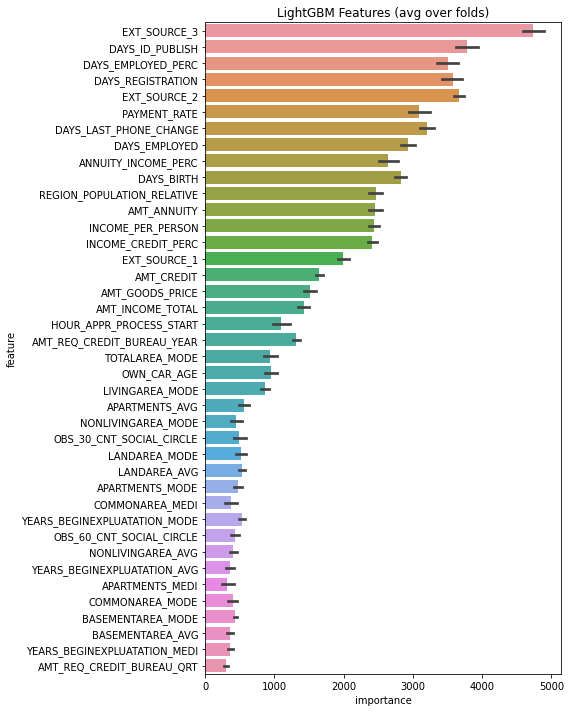

In [25]:
feat_importance, top_feat = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= False)

# Univaried analysis

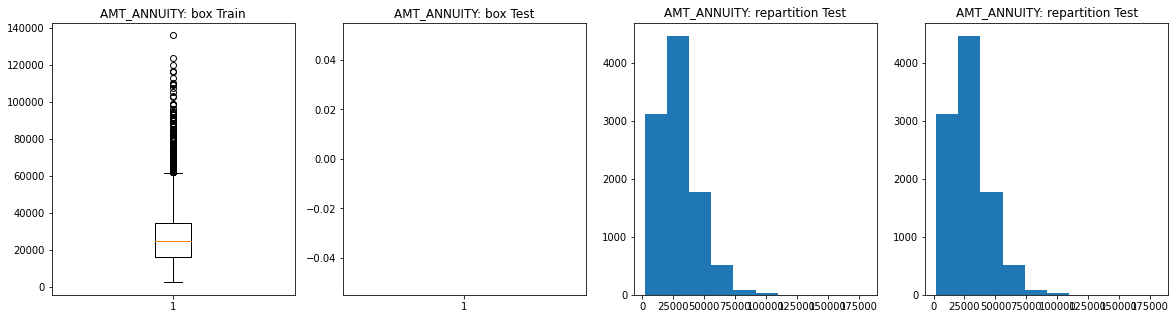

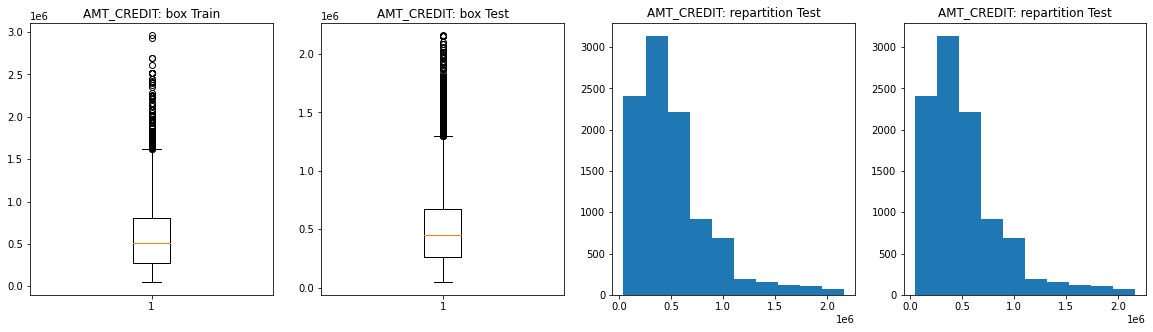

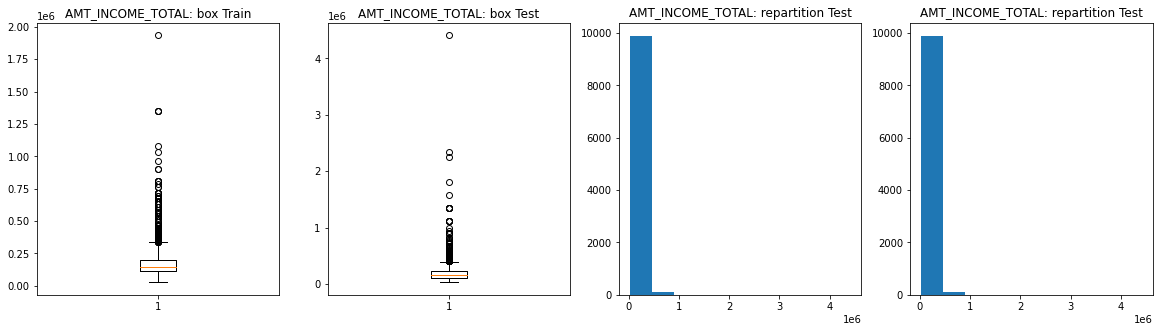

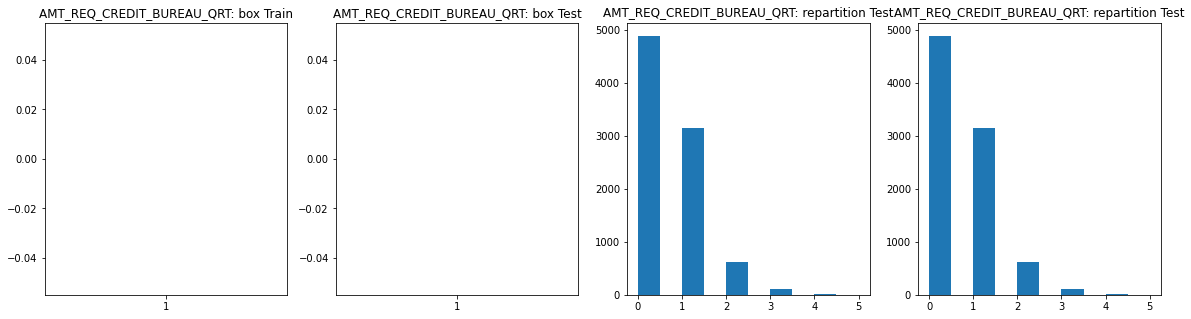

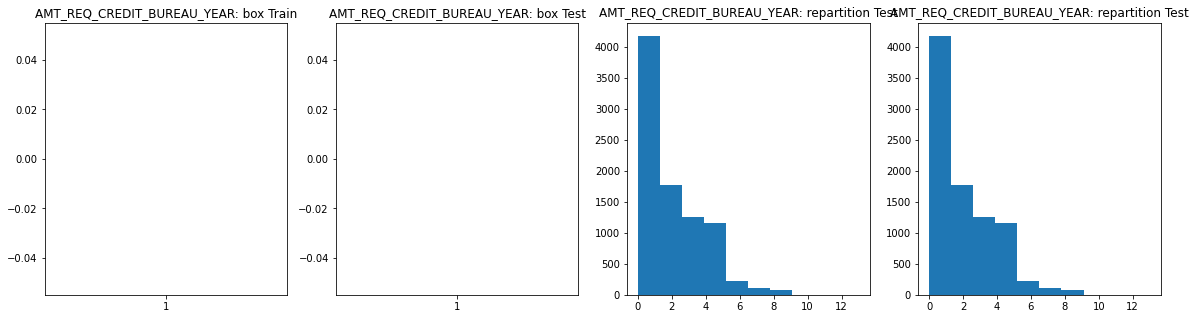

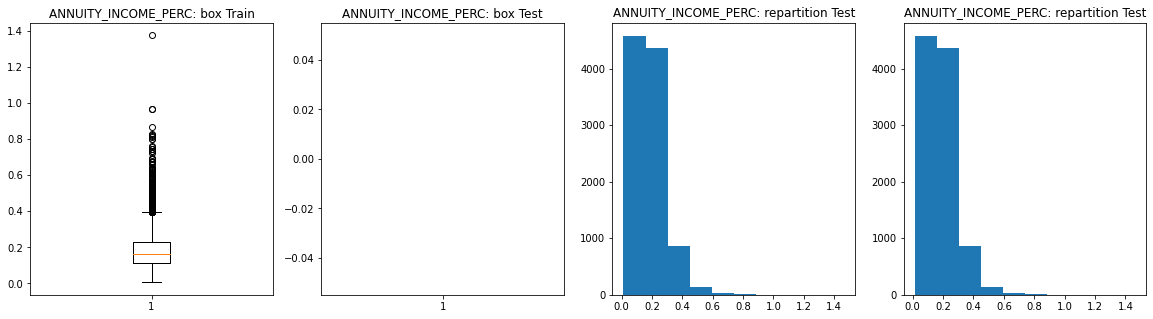

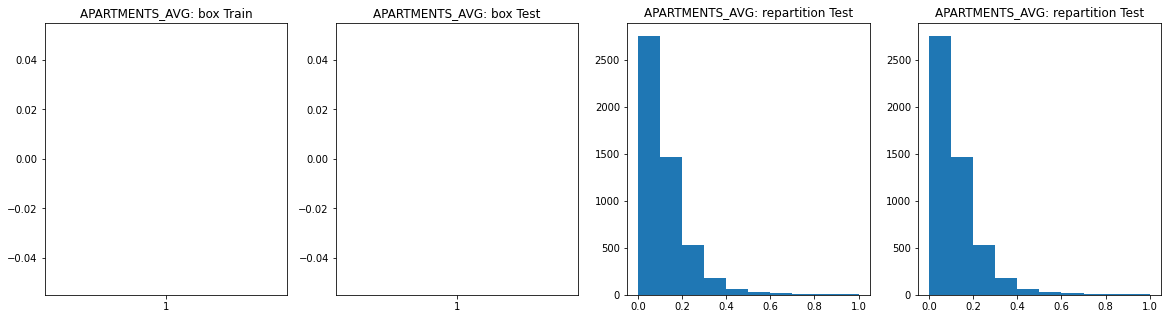

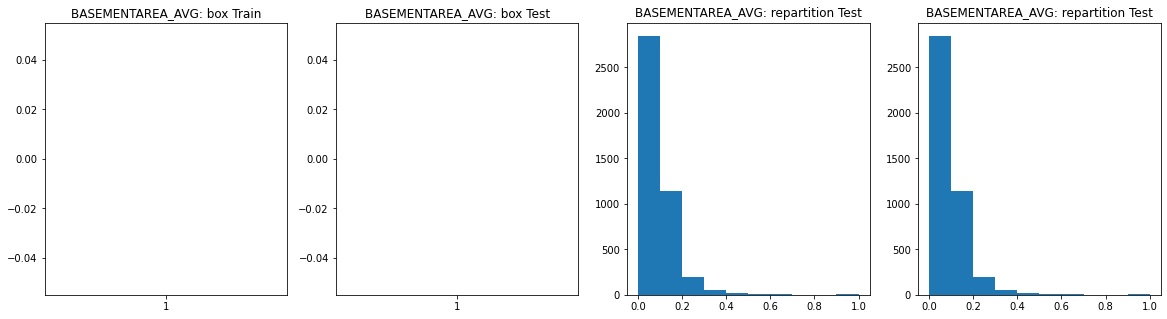

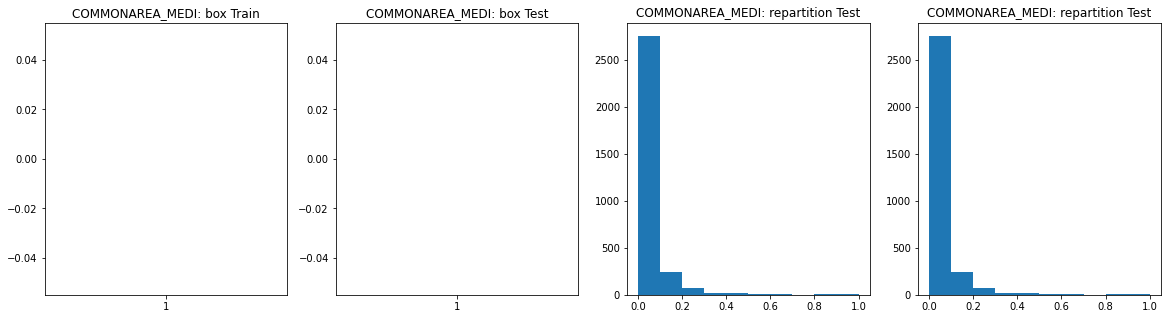

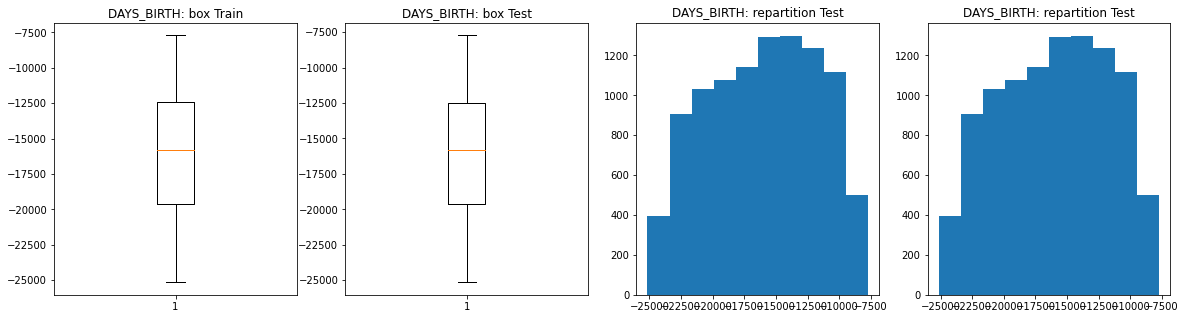

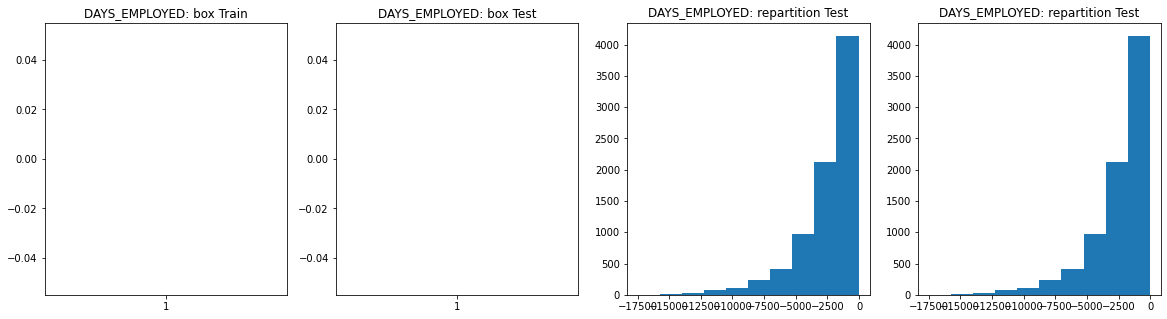

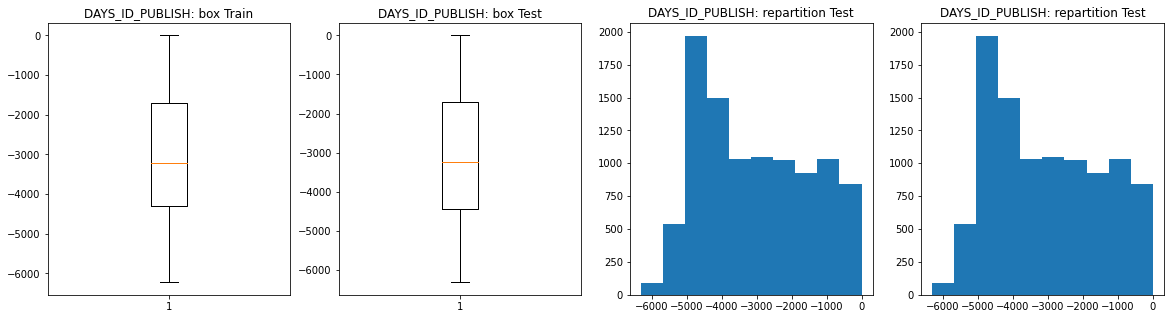

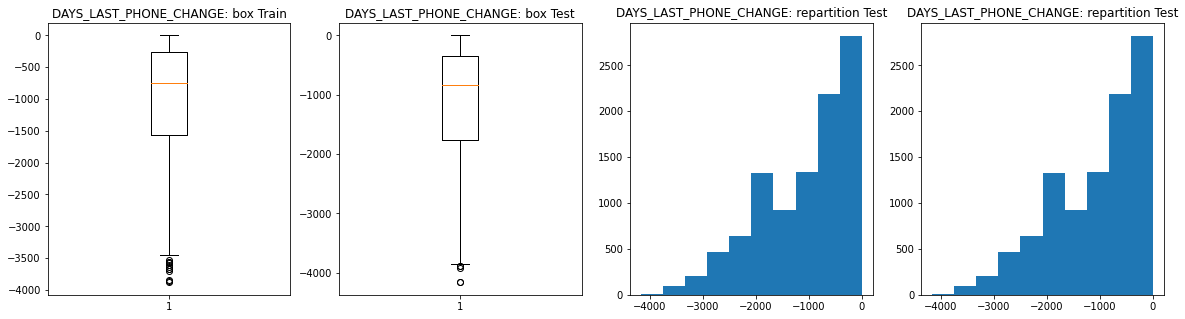

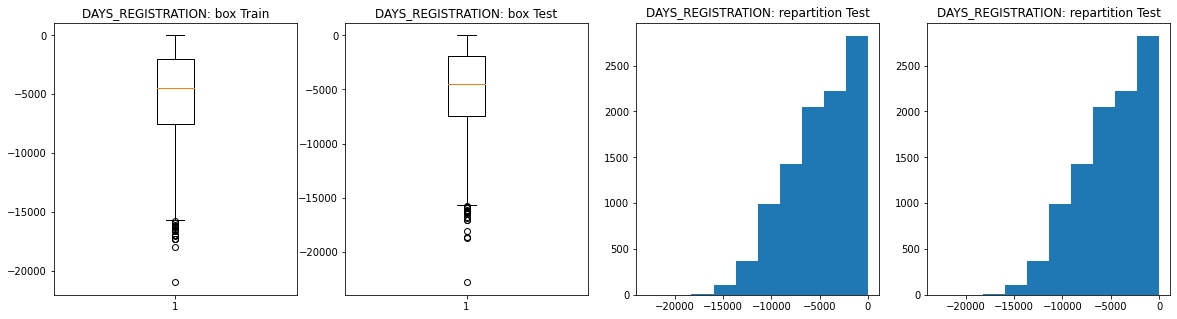

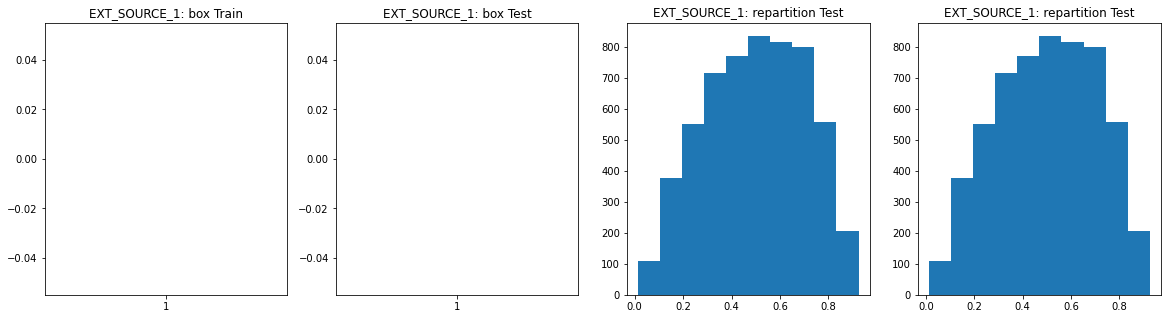

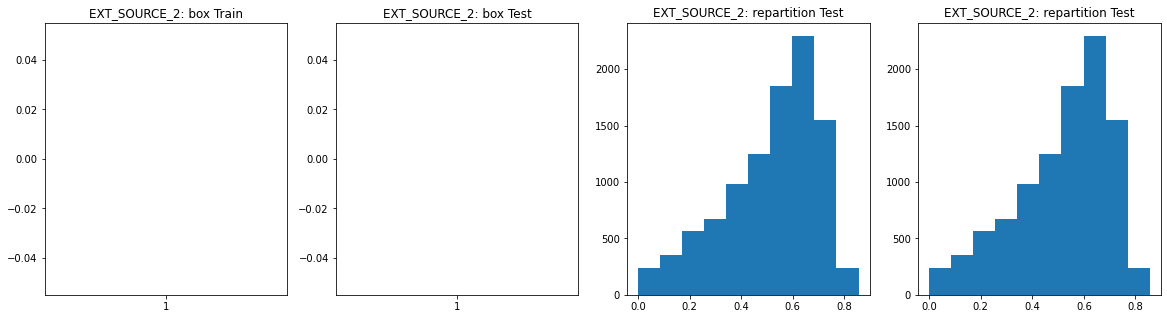

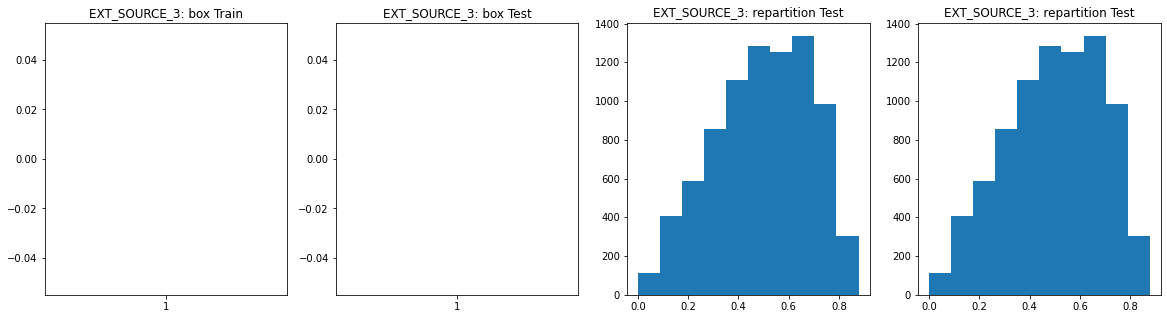

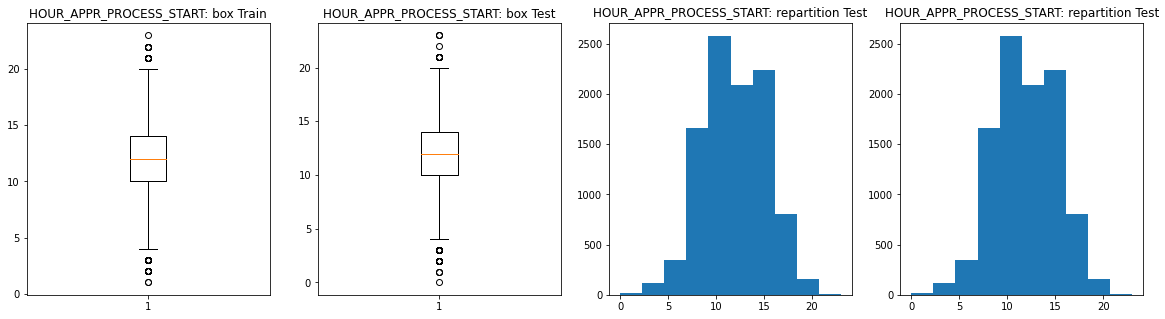

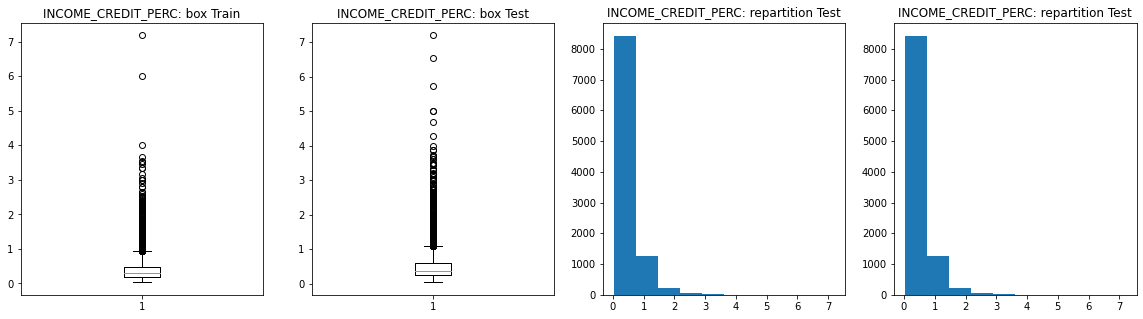

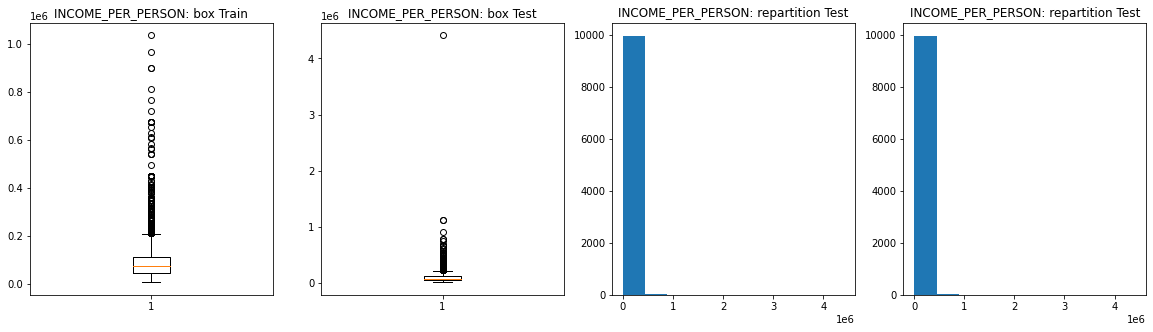

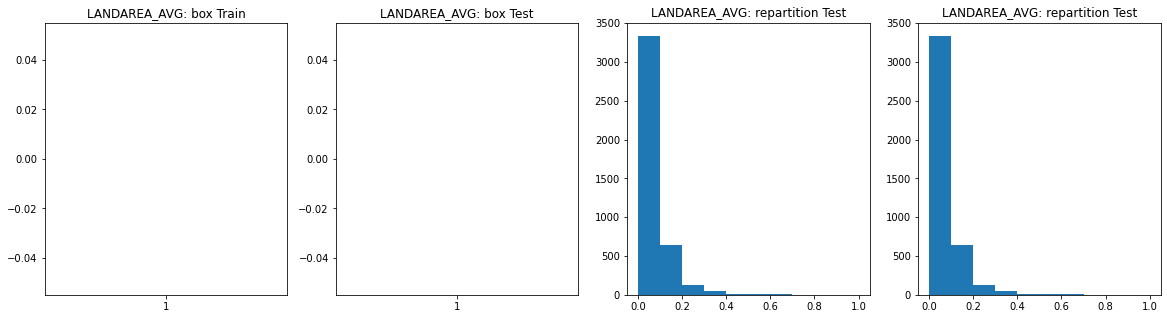

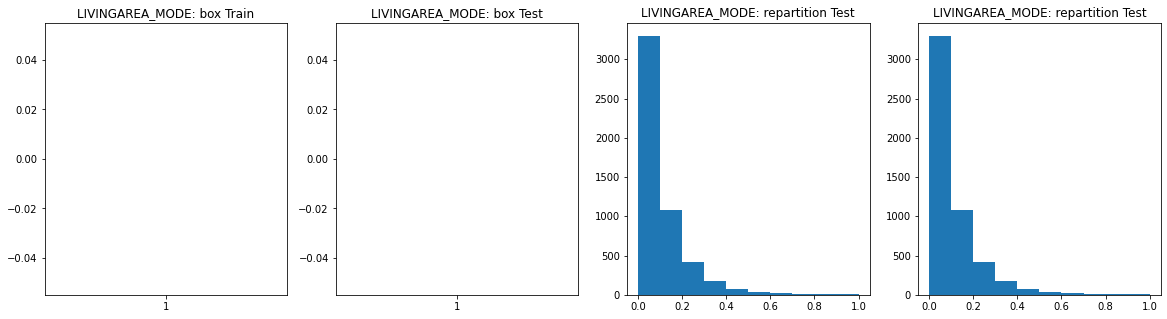

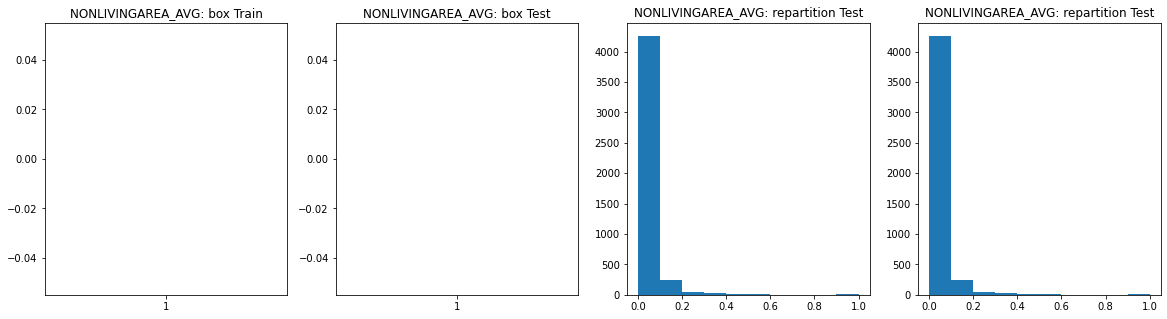

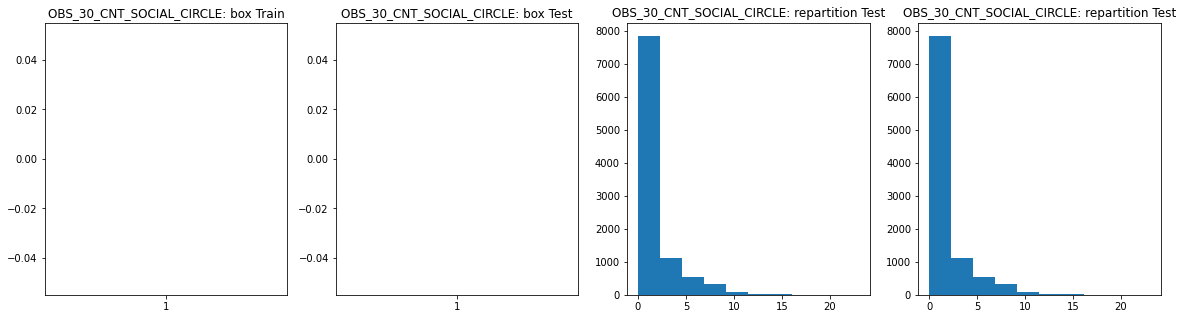

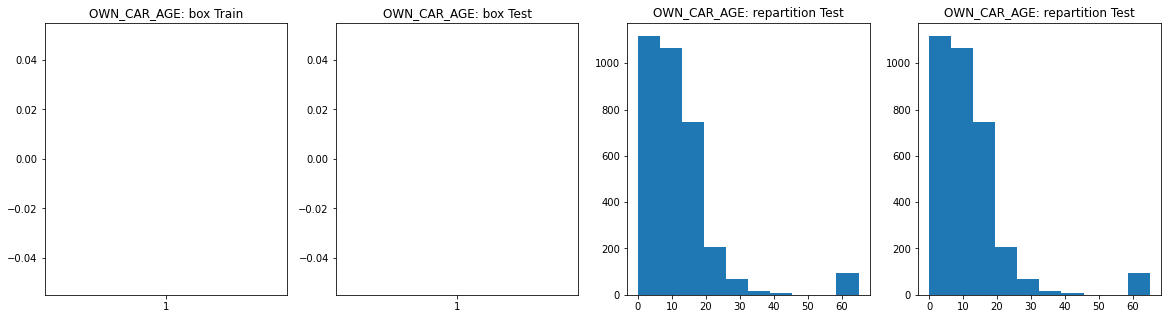

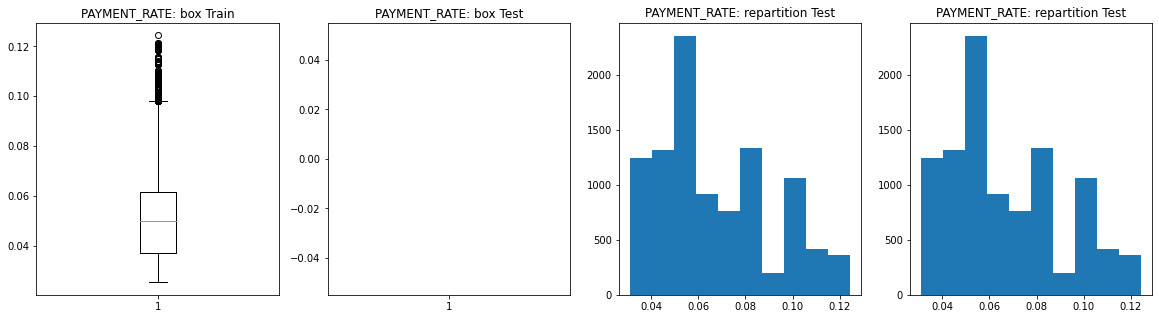

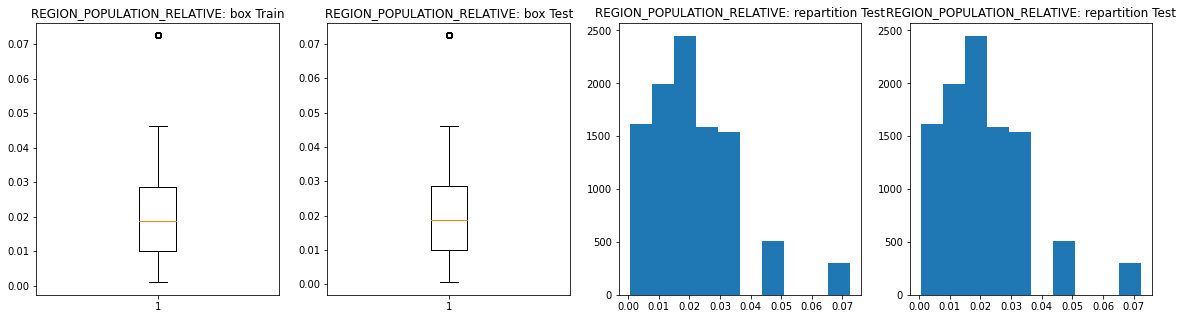

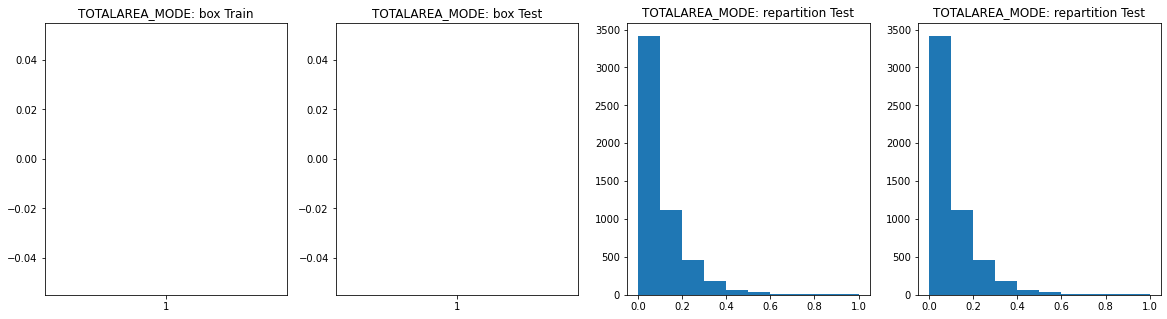

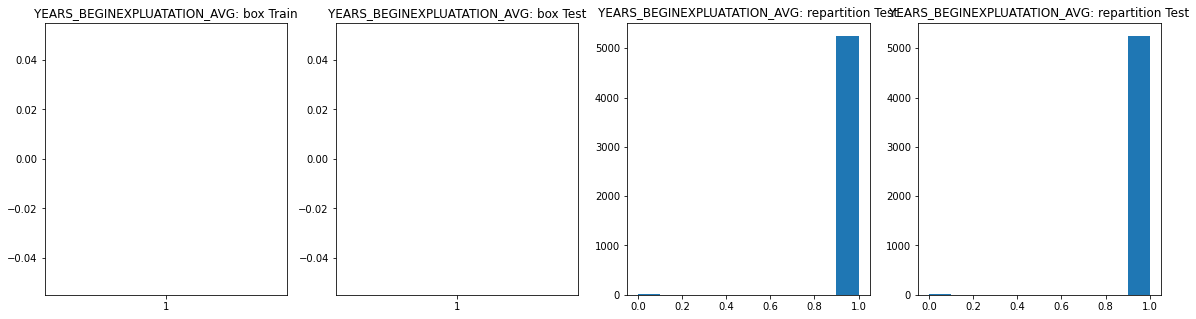

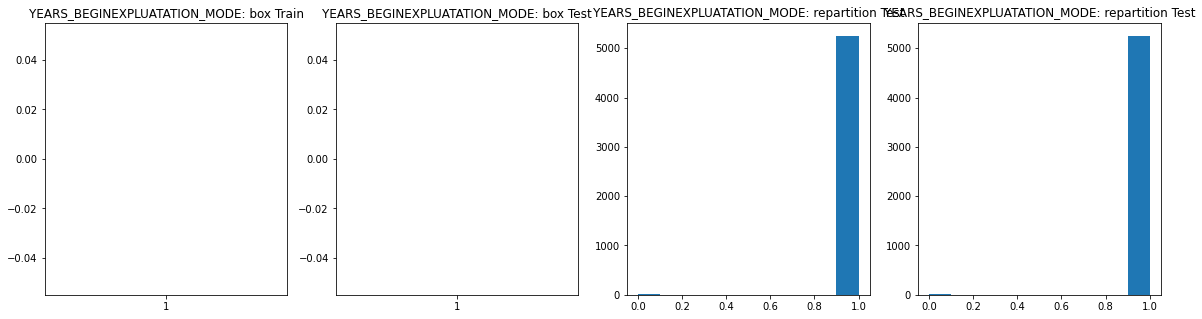

In [26]:
for feat in top_feat:
    plt.figure(figsize=(20,5))
    plt.subplot(1, 4, 1)
    plt.boxplot(df[feat][:num_rows])
    plt.title('{}: box Train'.format(feat))
    plt.subplot(1, 4, 2)
    plt.boxplot(df[feat][num_rows:])
    plt.title('{}: box Test'.format(feat))
    plt.subplot(1, 4, 3)
    plt.hist(df[feat][num_rows:])
    plt.title('{}: repartition Test'.format(feat))
    plt.subplot(1, 4, 4)
    plt.hist(df[feat][num_rows:])
    plt.title('{}: repartition Test'.format(feat))
    plt.show()

In [27]:
top_feat

['AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_INCOME_TOTAL',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'ANNUITY_INCOME_PERC',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'COMMONAREA_MEDI',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_REGISTRATION',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'HOUR_APPR_PROCESS_START',
 'INCOME_CREDIT_PERC',
 'INCOME_PER_PERSON',
 'LANDAREA_AVG',
 'LIVINGAREA_MODE',
 'NONLIVINGAREA_AVG',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'OWN_CAR_AGE',
 'PAYMENT_RATE',
 'REGION_POPULATION_RELATIVE',
 'TOTALAREA_MODE',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BEGINEXPLUATATION_MODE']

In [28]:
df_modele = df[top_feat + ['TARGET']]
df_modele

,AMT_ANNUITY,AMT_CREDIT,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,ANNUITY_INCOME_PERC,APARTMENTS_AVG,BASEMENTAREA_AVG,COMMONAREA_MEDI,DAYS_BIRTH,...,LIVINGAREA_MODE,NONLIVINGAREA_AVG,OBS_30_CNT_SOCIAL_CIRCLE,OWN_CAR_AGE,PAYMENT_RATE,REGION_POPULATION_RELATIVE,TOTALAREA_MODE,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MODE,TARGET
0,24700.5,406597.5,202500.0,0.0,1.0,0.121978,0.0247,0.0369,0.0144,-9461,...,0.0198,0.0000,2.0,NaN,0.060749,0.018801,0.0149,0.9722,0.9722,1.0
1,35698.5,1293502.5,270000.0,0.0,0.0,0.132217,0.0959,0.0529,0.0608,-16765,...,0.0554,0.0098,1.0,NaN,0.027598,0.003541,0.0714,0.9851,0.9851,0.0
2,6750.0,135000.0,67500.0,0.0,0.0,0.100000,NaN,NaN,NaN,-19046,...,NaN,NaN,0.0,26.0,0.050000,0.010032,NaN,NaN,NaN,0.0
3,29686.5,312682.5,135000.0,NaN,NaN,0.219900,NaN,NaN,NaN,-19005,...,NaN,NaN,2.0,NaN,0.094941,0.008019,NaN,NaN,NaN,0.0
4,21865.5,513000.0,121500.0,0.0,0.0,0.179963,NaN,NaN,NaN,-19932,...,NaN,NaN,0.0,NaN,0.042623,0.028663,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,29173.5,454500.0,135000.0,0.0,0.0,0.216100,0.0979,0.0552,NaN,-18338,...,0.1028,0.1145,0.0,NaN,0.064188,0.028663,0.0721,0.9717,0.9717,NaN
19996,52555.5,500490.0,180000.0,0.0,1.0,0.291975,0.0577,NaN,NaN,-15040,...,0.0318,0.0104,2.0,18.0,0.105008,0.046220,0.0020,0.9752,0.9752,NaN
19997,37336.5,523152.0,202500.0,NaN,NaN,0.184378,0.1381,0.1397,NaN,-17225,...,0.1256,0.0039,0.0,NaN,0.071368,0.032561,0.0956,0.9752,0.9752,NaN
19998,31338.0,967500.0,382500.0,0.0,3.0,0.081929,0.2603,0.1686,0.0385,-14852,...,0.1473,0.0064,1.0,NaN,0.032391,0.072508,0.2784,0.9791,0.9791,NaN


In [29]:
df_modele_train = df_modele[:num_rows].fillna(0)
df_modele_test = df_modele[num_rows:].fillna(0)

# Target observations

In [30]:
df_modele_train.TARGET.value_counts()

0.0    9225
1.0     775
Name: TARGET, dtype: int64

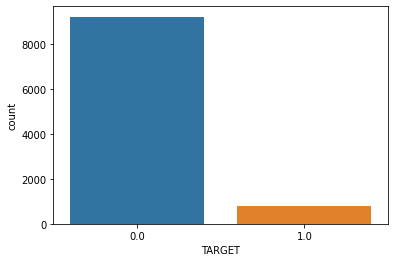

In [31]:
sns.countplot(x=df_modele_train.TARGET)
plt.show()

# Classification
#### KNN, SVC

### Undersampling

In [32]:
class_count_0, class_count_1 = df_modele_train['TARGET'].value_counts()

In [33]:
class_0 = df_modele_train[df_modele_train['TARGET'] == 0]
class_1 = df_modele_train[df_modele_train['TARGET'] == 1]
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (9225, 31)
class 1: (775, 31)


total class:
 0.0    775
1.0    775
Name: TARGET, dtype: int64


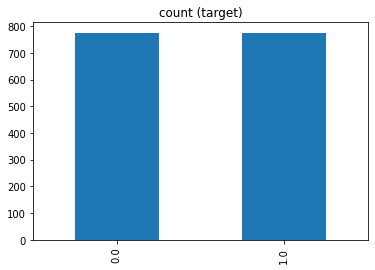

In [34]:
# get random sample of class 1
class_0_under = class_0.sample(class_count_1)

test_under = pd.concat([class_0_under, class_1], axis=0)

print("total class:\n",test_under['TARGET'].value_counts())
test_under['TARGET'].value_counts().plot(kind='bar', title='count (target)')
plt.show()

In [35]:
def train_test_grid(x, y, method='knn', n_esti=None):
    if method == 'knn':
        params = {
            'n_neighbors': list(range(15, 30)),
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
        }
        mthd = KNeighborsClassifier()
    elif method == 'svc':
        params = {
            'penalty': ['l1', 'l2'],
            'multi_class': ['crammer_singer', 'ovr']
        }
        mthd = LinearSVC(random_state=0, max_iter=2000, tol=0.0001)
    elif method == 'sgd':
        params = {
            'penalty': ['l1', 'l2'],
            'tol': [0.0001, 0.001, 0.01, 0.1]
        }
        mthd = SGDClassifier(random_state=0)
    elif method == 'dummy':
        params = {
            'strategy': ['most_frequent', 'prior', 'stratified', 'uniform', 'constant']
        }
        mthd = DummyClassifier(random_state=0)
    else:
        print('Wrong method input, please make sure you entered either "knn" or "svc"')
        
    X_train, X_test, y_train, y_test = train_test_split(
        x,
        y,
        test_size=0.33,
        random_state=0)
    
    grid = GridSearchCV(mthd, param_grid=params)
    grid.fit(X_train, y_train)
    print('Grid best score :', grid.score(X_test, y_test))
    print('Grid best params :', grid.best_params_)
    
    cls = mthd.set_params(**grid.best_params_)
    
    plot_idx = 1
    if n_esti:
        print('Bagging with {} estimators'.format(n_esti))
        bagged_cls = BaggingClassifier(cls, n_estimators=n_esti)
        bagged_cls.fit(X_train, y_train)
        pred = bagged_cls.predict(X_test)
        true = y_test.values
        
        plt.subplot(1, 2, plot_idx)
        plt.figure(figsize=(10, 5))
        sns.heatmap(confusion_matrix(true, pred), annot=True, cmap="Blues")
        plt.title('{} confusion matrix (score = {})'.format(
            method.upper(),
            bagged_cls.score(X_test, y_test)))
        plot_idx += 1
        
    cls.fit(X_train, y_train)
    pred = cls.predict(X_test)
    true = y_test.values
    plt.subplot(1, 2, plot_idx)
    plt.figure(figsize=(10, 5))
    sns.heatmap(confusion_matrix(true, pred), annot=True, cmap="Blues")
    plt.title('{} confusion matrix (score = {})'.format(
        method.upper(),
        cls.score(X_test, y_test)))
    plt.show()

C:\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Python\Python39\lib\site-packages\sklearn\dummy.py", line 205, in fit
    raise ValueError(
ValueError: Constant target value has to be specified when the constant strategy is used.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
C:\Python\Python39\lib\site-packages\sklearn\model_selection\_search.p

Grid best score : 0.494140625
Grid best params : {'strategy': 'most_frequent'}
Bagging with 100 estimators
{} bagged score : 0.494140625


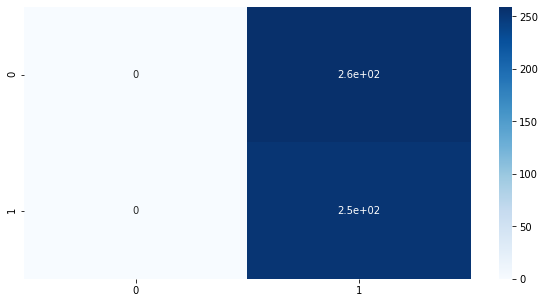

In [36]:
train_test_grid(test_under[top_feat], test_under.TARGET, method='dummy')

Grid best score : 0.53515625
Grid best params : {'penalty': 'l1', 'tol': 0.0001}
Bagging with 100 estimators
{} bagged score : 0.546875


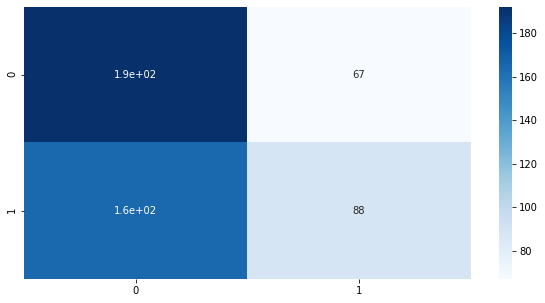

In [37]:
train_test_grid(test_under[top_feat], test_under.TARGET, method='sgd', n_esti=50)

In [38]:
#train_test_grid(test_under[top_feat], test_under.TARGET, method='svc')

Grid best score : 0.53125
Grid best params : {'algorithm': 'auto', 'n_neighbors': 29}
Bagging with 100 estimators
{} bagged score : 0.541015625


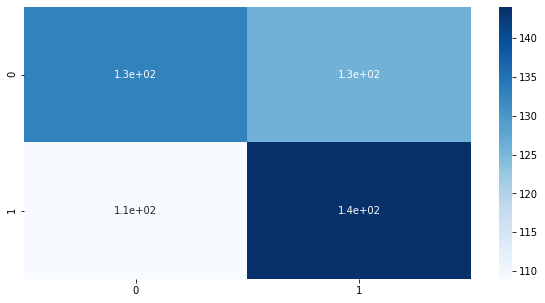

In [39]:
train_test_grid(test_under[top_feat], test_under.TARGET, method='knn', n_esti=50)

### Oversampling

total class of 1 and 0: 0.0    9225
1.0    9225
Name: TARGET, dtype: int64


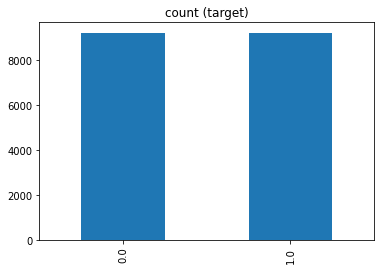

In [40]:
class_1_over = class_1.sample(class_count_0, replace=True)

test_over = pd.concat([class_1_over, class_0], axis=0)

print("total class of 1 and 0:",test_over['TARGET'].value_counts())
test_over['TARGET'].value_counts().plot(kind='bar', title='count (target)')
plt.show()

C:\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Python\Python39\lib\site-packages\sklearn\dummy.py", line 205, in fit
    raise ValueError(
ValueError: Constant target value has to be specified when the constant strategy is used.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
C:\Python\Python39\lib\site-packages\sklearn\model_selection\_search.p

Grid best score : 0.49499096731811465
Grid best params : {'strategy': 'most_frequent'}
Bagging with 100 estimators
{} bagged score : 0.49499096731811465


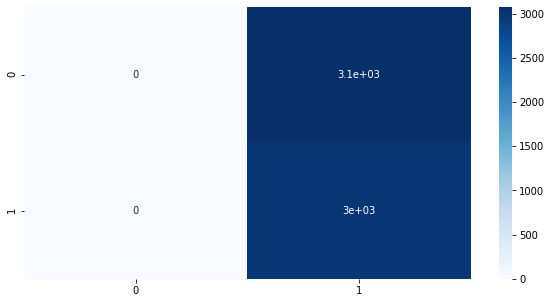

In [41]:
train_test_grid(test_over[top_feat], test_over.TARGET, method='dummy')

Grid best score : 0.6813926753161439
Grid best params : {'algorithm': 'auto', 'n_neighbors': 15}
Bagging with 100 estimators
{} bagged score : 0.696337658071933


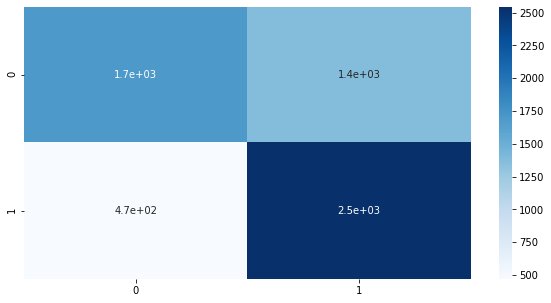

In [42]:
train_test_grid(test_over[top_feat], test_over.TARGET, method='knn', n_esti=50)

Grid best score : 0.5142059451469864
Grid best params : {'penalty': 'l2', 'tol': 0.0001}
Bagging with 100 estimators
{} bagged score : 0.5713581868943998


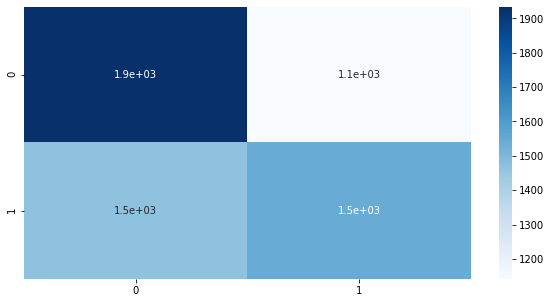

In [43]:
train_test_grid(test_over[top_feat], test_over.TARGET, method='sgd', n_esti=50)

In [44]:
#train_test_grid(test_over[top_feat], test_over.TARGET, method='svc')

### SMOTE

In [45]:
smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(df_modele_train[top_feat], df_modele_train.TARGET)

print('Original dataset shape', df_modele_train[top_feat].shape)
print('Resample dataset shape', x_smote.shape)

Original dataset shape (10000, 30)
Resample dataset shape (18450, 30)


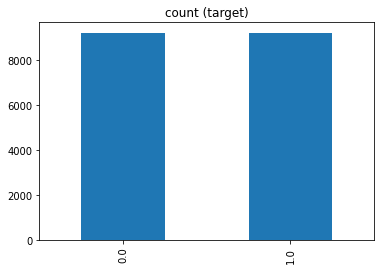

In [46]:
y_smote.value_counts().plot(kind='bar', title='count (target)')
plt.show()

C:\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Python\Python39\lib\site-packages\sklearn\dummy.py", line 205, in fit
    raise ValueError(
ValueError: Constant target value has to be specified when the constant strategy is used.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
C:\Python\Python39\lib\site-packages\sklearn\model_selection\_search.p

Grid best score : 0.5109213335523074
Grid best params : {'strategy': 'stratified'}
Bagging with 100 estimators
{} bagged score : 0.5002463458696009


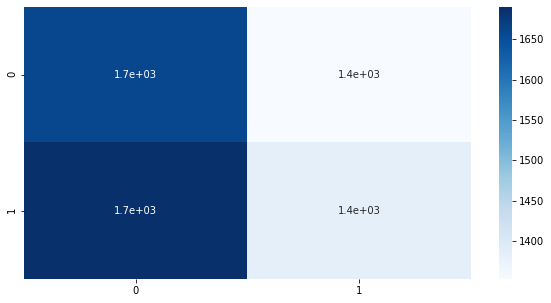

In [47]:
train_test_grid(x_smote, y_smote, method='dummy')

Grid best score : 0.739366069962227
Grid best params : {'algorithm': 'auto', 'n_neighbors': 16}
Bagging with 100 estimators
{} bagged score : 0.7339464608310068


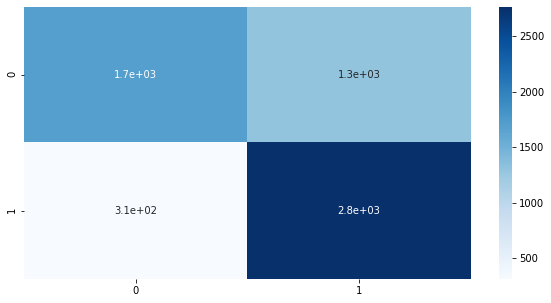

In [48]:
train_test_grid(x_smote, y_smote, method='knn', n_esti=50)

Grid best score : 0.4925275086221054
Grid best params : {'penalty': 'l1', 'tol': 0.0001}
Bagging with 100 estimators
{} bagged score : 0.5325997700771884


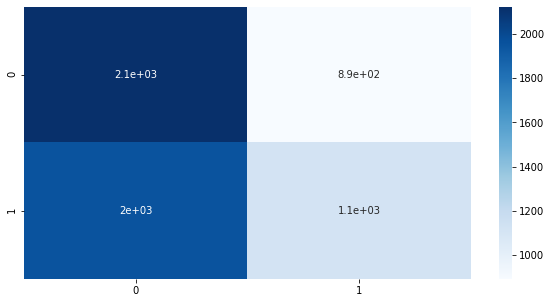

In [49]:
train_test_grid(x_smote, y_smote, method='sgd', n_esti=50)